In [1]:
!pip install rembg==2.0.56

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00


# Imports

In [2]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from skimage import exposure
from rembg import new_session, remove
from sklearn.metrics.pairwise import cosine_similarity

# Constants

In [3]:
BASE_PATH = '/kaggle/input/key-images/'

# Model

In [4]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, cropped_feature=None, key_contour=None):
        self.rgb_img = rgb_img                 # Original Img (RGB)
        self.mask_img = mask_img               # Orignal Img Mask (Binary)
        self.cropped_mask = cropped_mask       # Cropped Mask (Rotated + Binary)
        self.cropped_feature = cropped_feature # Cropped Feature (Rotated + Grayscale)
        self.key_contour = key_contour         # Key Contour

# Helper Functions

In [5]:
def extract_key_boundary_from_masked_img(masked_img):
    # Convert image to numpy
    gray_img = np.array(key_images[-2].mask_img)

    # Remove noise using Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, 30, 150)
    
    return edges


def resize_binary_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_binary_image(image, DIMENSION)


def resize_binary_image_to_512X512(image):
    WIDTH = 488
    HEIGHT = 488
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_binary_image(image, DIMENSION)


def resize_grayscale_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_grayscale_image_to_512X512(image):
    WIDTH = 488
    HEIGHT = 488
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_binary_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    # Replace with 1s and 0s
    for idx, row in enumerate(canvas):
        new_row = np.where(row > 0, 1, row)
        canvas[idx] = new_row
    
    return canvas


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    return canvas


def fix_mask_image_size(image):
    PADDING = 12
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)

    # Create a blank canvas of the desired size
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    # Calculate the offset to center the image on the canvas
    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image

    return canvas


def is_ellipse_center_below_lower_half(center, image_shape):
    center_x, center_y = center
    image_width, image_height = image_shape
    return True if (center_y > image_height / 2) else False


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90
    
    return (new_angle + 180) if is_below else (new_angle + 180)


def bit_packing(binary_image):
    # Reshape the image to a 1D array
    flat_image = binary_image.ravel()

    # Calculate the number of pixels that can be packed into a single byte
    bits_per_pixel = 1
    bits_per_byte = 8
    packed_image = np.packbits(flat_image.reshape(-1, bits_per_byte // bits_per_pixel), axis=1)

    return packed_image


def bit_unpacking(packed_image, width, height):
    # Calculate the number of pixels per byte
    bits_per_pixel = 1
    bits_per_byte = 8
    pixels_per_byte = bits_per_byte // bits_per_pixel

    # Reshape the packed image to 1D array
    packed_image = packed_image.ravel()

    # Calculate the total number of bytes needed to store the unpacked image
    total_pixels = width * height
    total_bytes = total_pixels // pixels_per_byte
    if total_pixels % pixels_per_byte != 0:
        total_bytes += 1

    # Pad the packed image with zeros to ensure it has the correct length
    packed_image = np.pad(packed_image, (0, total_bytes * pixels_per_byte - len(packed_image)), mode='constant')

    # Unpack the image
    unpacked_image = np.unpackbits(packed_image)

    # Reshape the unpacked image to the original shape
    unpacked_image = unpacked_image[:total_pixels].reshape((height, width))

    return unpacked_image


def flatten_image_data(image_data):
    return np.frombuffer(image_data, dtype=np.uint8)

In [6]:
def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def get_dataset_images_path(base_path):
    image_names = []
    images_path = []
    for _, _, img_names in os.walk(base_path):
        image_names.extend(img_names)
    
    images_path = [os.path.join(base_path, img_name) for img_name in image_names if "csv" not in img_name]
    return images_path


def plt_contour(contour):
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Create an empty black image with dimensions based on the bounding box
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Draw the contour on the black image with the contour shifted to the top-left corner of the bounding box
    shifted_contour = contour - np.array([x, y])
    contour_image = cv2.drawContours(blank_image, [shifted_contour], -1, (0, 0, 255), thickness=cv2.FILLED)
    
    plt_img(contour_image)


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

In [7]:
def pack_bits(grayscale_img, num_bits=2):
    # Flatten the image to 1D array
    flattened_img = grayscale_img.flatten()
    
    # Pack the bits
    packed_bits = bytearray()
    current_byte = 0
    bit_position = 0
    
    for pixel_value in flattened_img:
        current_byte |= (pixel_value & ((1 << num_bits) - 1)) << (8 - num_bits - bit_position)
        bit_position += num_bits
        
        while bit_position >= 8:
            packed_bits.append(current_byte)
            current_byte = 0
            bit_position -= 8
    
    # If there are remaining bits in the last byte, add it to the packed bits
    if bit_position > 0:
        packed_bits.append(current_byte)
    
    return packed_bits

def unpack_bits(packed_bits, original_shape, num_bits=2):
    # Unpack the bits
    unpacked_img = np.zeros(original_shape, dtype=np.uint8)
    
    bit_index = 0
    byte_index = 0
    
    for i in range(original_shape[0]):
        for j in range(original_shape[1]):
            bit_position = 8 - (bit_index % 8) - num_bits
            unpacked_img[i][j] = (packed_bits[byte_index] >> bit_position) & ((1 << num_bits) - 1)
            bit_index += num_bits
            
            while bit_index >= 8:
                byte_index += 1
                bit_index -= 8
    
    return unpacked_img

# Step 1: Mask Keys in image

In [8]:
# 1. Get images path
images_path = sorted(get_dataset_images_path(BASE_PATH))

# 2. Read images
key_images = []
for image_path in images_path:
    # 2a. Read img and adjust its brightness
    rgb_img = np.array(Image.open(image_path))

    # brightness_factor = 1.5  # Increase brightness by 50%
    # rgb_img = cv2.convertScaleAbs(rgb_img, alpha=brightness_factor, beta=0)

    # 2b. Make a grayscale copy and also create an empty grayscale image
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 2c. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 2d. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 2e. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]

    # 2f. Extract and paste only region of interest to grayscale image
    cv2.drawContours(empty_img, contours, -1, (255), thickness=cv2.FILLED)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)
    # cropped_feature = cropped_feature[y:y+h, x:x+w]
    
    key_images.append(
        ImageModel(rgb_img=np.array(rgb_img),
                   mask_img=mask_img,
                   cropped_mask=cropped_mask,
                   cropped_feature=cropped_feature,
                   key_contour=contours[0])
    )

100%|████████████████████████████████████████| 179M/179M [00:00<00:00, 133GB/s]


In [9]:
# for img in key_images:
#     plt_contour(img.key_contour)

In [10]:
# for img in key_images[1:4]:
#     fig, axs = plt.subplots(2, 2)

#     axs[0, 0].imshow(img.rgb_img)
#     axs[0, 1].imshow(img.mask_img, cmap='binary')
#     axs[1, 0].imshow(img.cropped_mask, cmap='binary')
#     axs[1, 1].imshow(img.cropped_feature, cmap='gray')

#     plt.tight_layout()
#     plt.show()

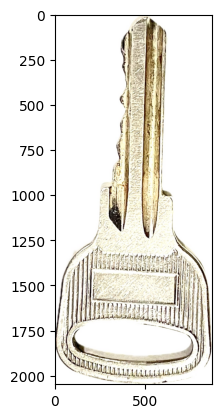

In [11]:
plt_img(key_images[0].rgb_img)

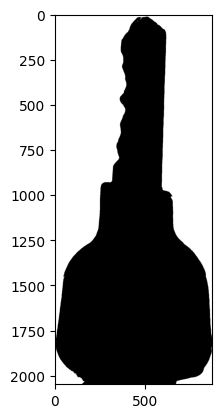

In [12]:
plt_img(key_images[0].mask_img, cmap='binary')

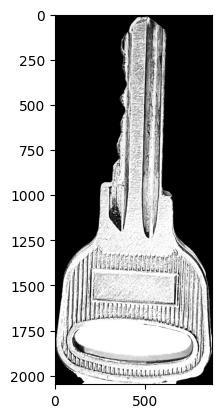

In [13]:
plt_img(key_images[0].cropped_feature, cmap='gray')

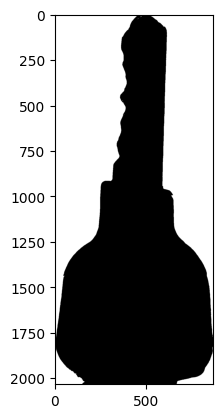

In [14]:
plt_img(key_images[0].cropped_mask, cmap='binary')

# Step 2: Transform Image (Rotation)

In [15]:
for image in key_images:
    masked_image = image.mask_img
    grayscae_image = image.cropped_feature

    # 1. Fit an ellipse to the key contour
    ellipse = cv2.fitEllipse(image.key_contour) 

    # 2. Get ellipse properties
    center, axis_lengths, current_angle = ellipse

    # 3. Rotate image
    # Ellipse center is near to key holding area (if lower than key is facing upwards in image)
    is_below = is_ellipse_center_below_lower_half(center,masked_image.shape)
    rotation_angle = get_rotation_angle(is_below, current_angle)
    
    # 4. Fix grayscale and binary image size before applying rotation
    fixed_binary_image = fix_mask_image_size(masked_image)
    fixed_grayscale_image = fix_mask_image_size(grayscae_image)

    # 5. Apply rotation
    center = (fixed_binary_image.shape[1] // 2, fixed_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    
    rotated_binary_image = cv2.warpAffine(fixed_binary_image, rot_mat, fixed_binary_image.shape[1::-1])
    rotated_grayscale_image = cv2.warpAffine(fixed_grayscale_image, rot_mat, fixed_grayscale_image.shape[1::-1])
    
    # 6. Cropped the rotated masked img
    contours, _ = cv2.findContours(rotated_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y:y+h, x:x+w]
    rotated_grayscale_image = rotated_grayscale_image[y:y+h, x:x+w]
    
    # 7. Updated cropped masked
    image.cropped_mask = rotated_binary_image
    image.cropped_feature = rotated_grayscale_image

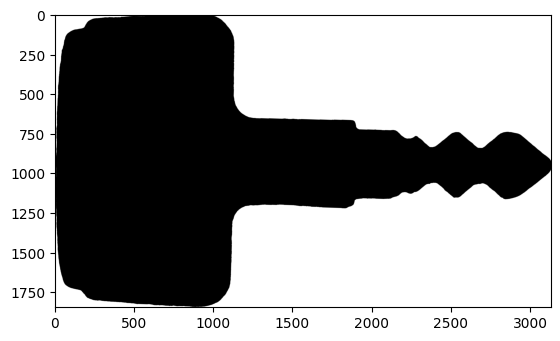

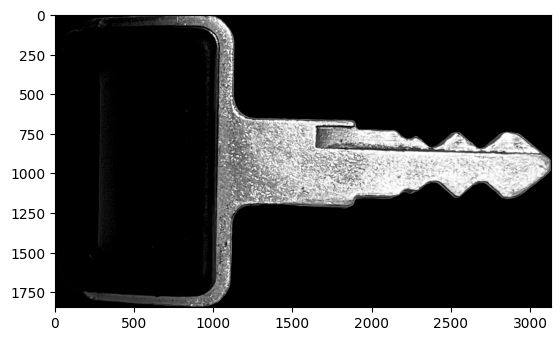

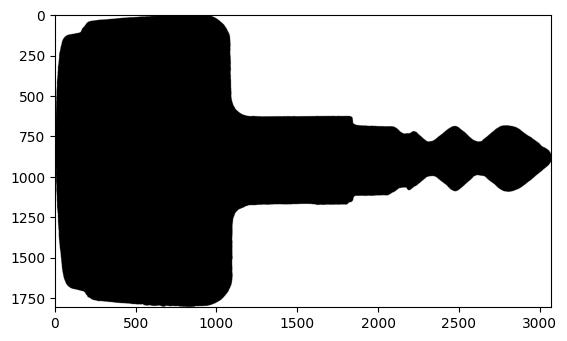

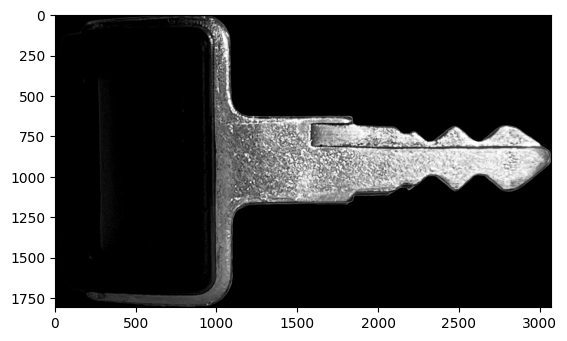

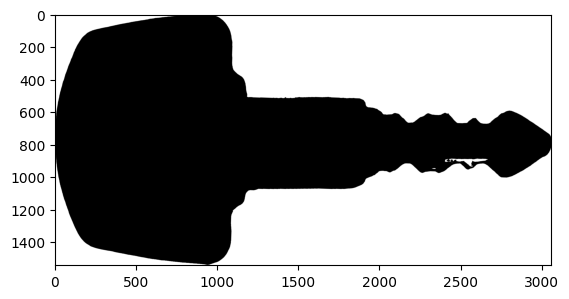

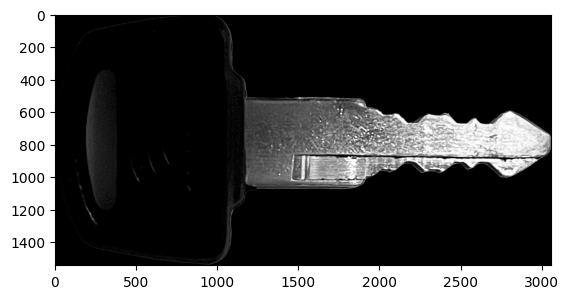

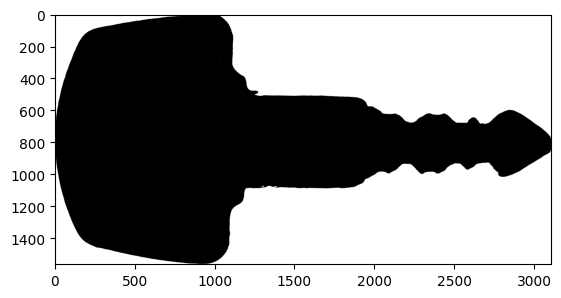

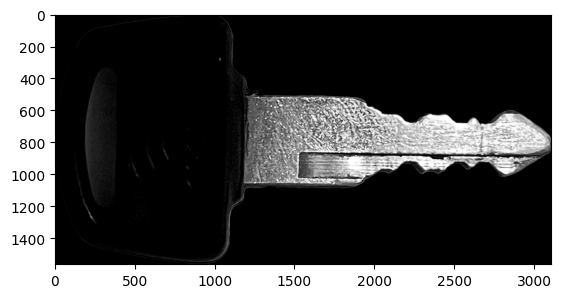

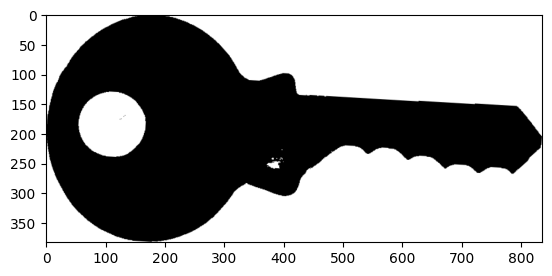

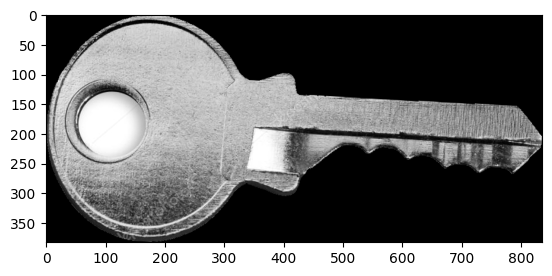

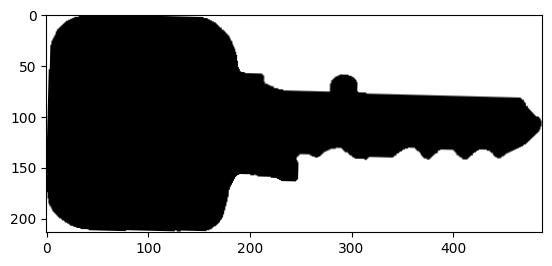

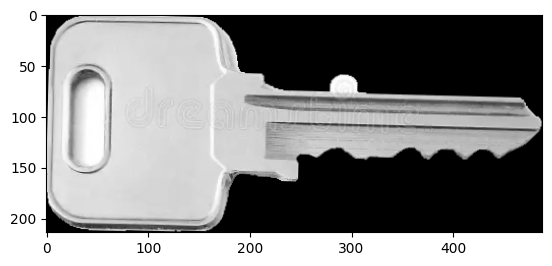

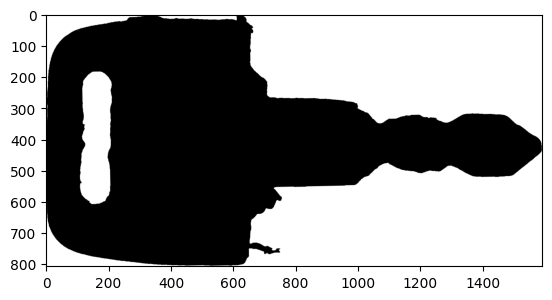

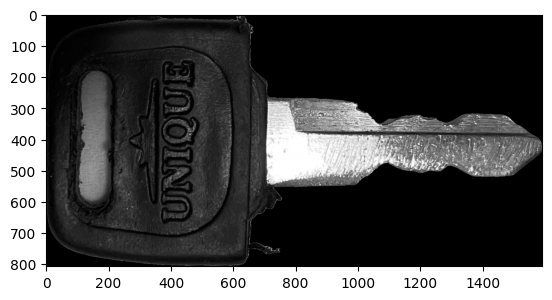

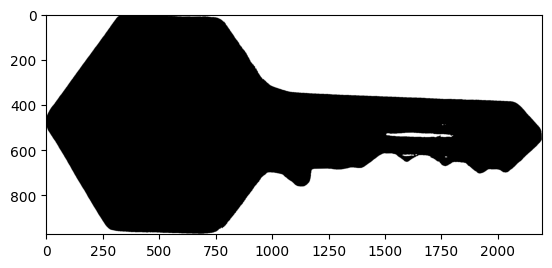

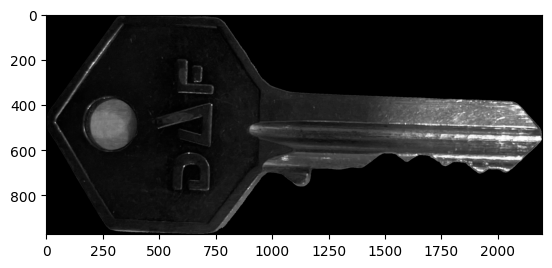

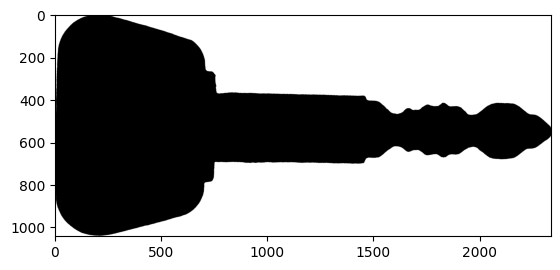

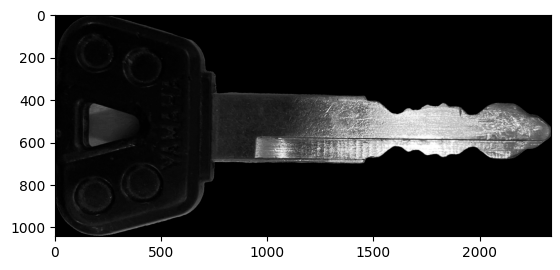

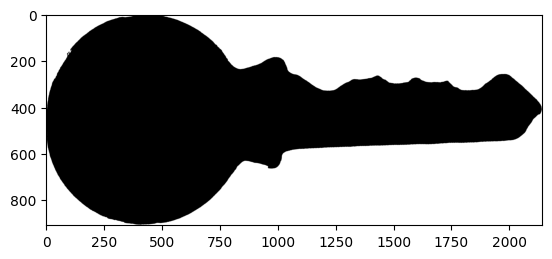

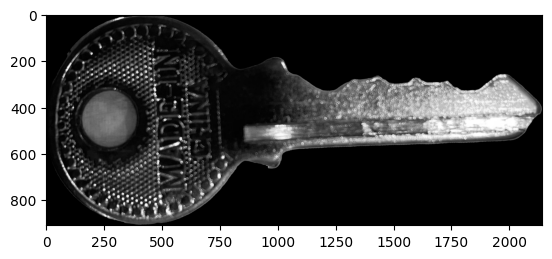

In [16]:
for img in key_images[9:]:
    plt_img(img.cropped_mask, cmap='binary')
    plt_img(img.cropped_feature, cmap='gray')

# Step 3: Resize / Standardise / Normalise keys to 256x256

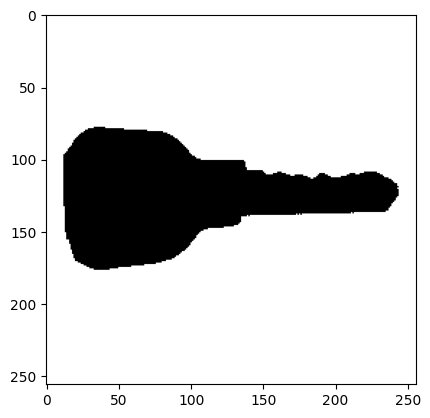

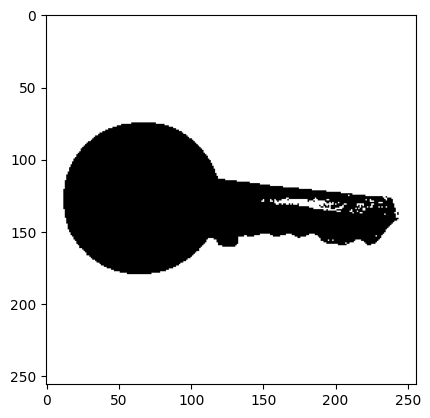

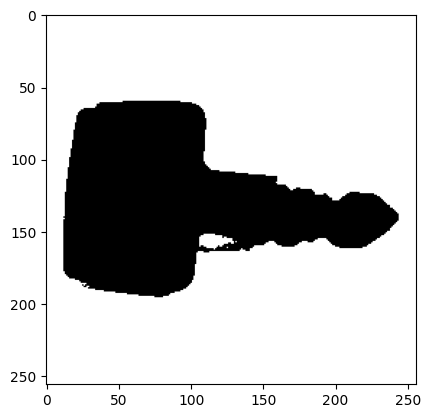

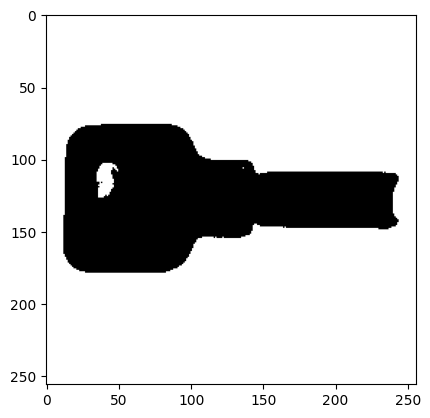

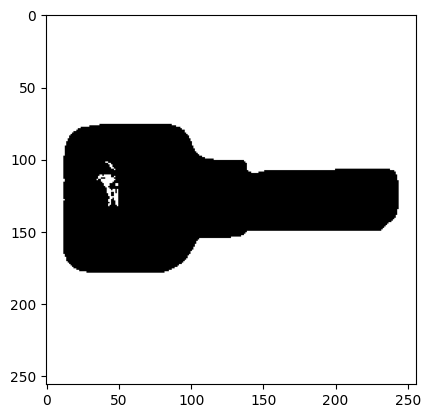

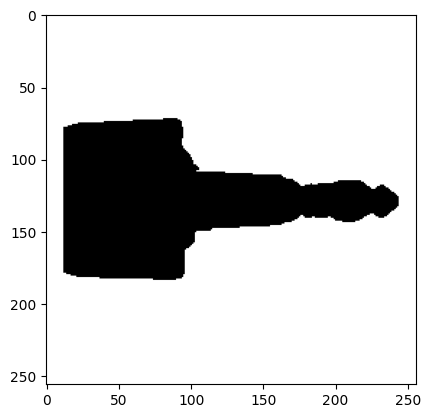

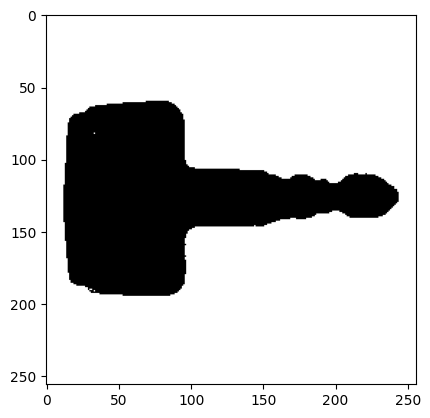

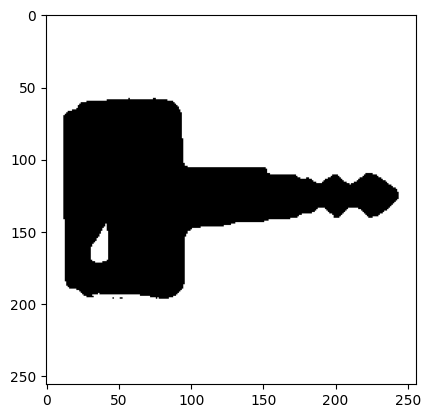

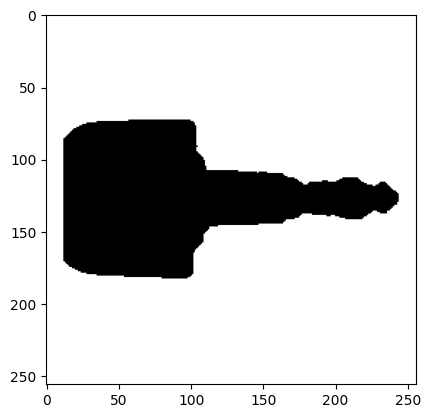

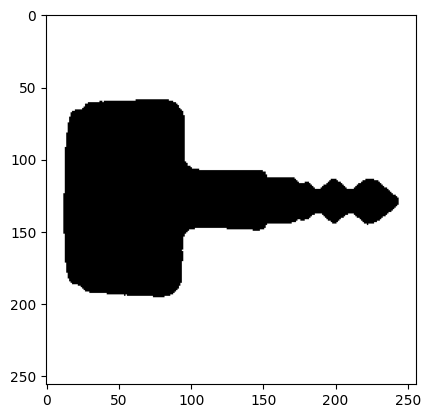

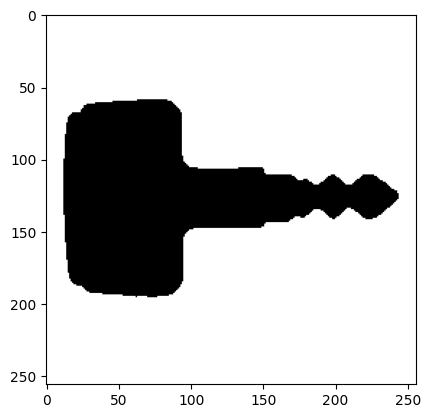

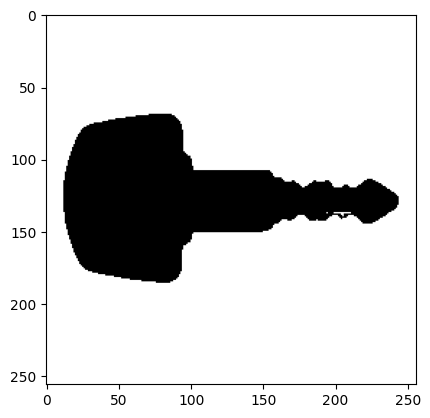

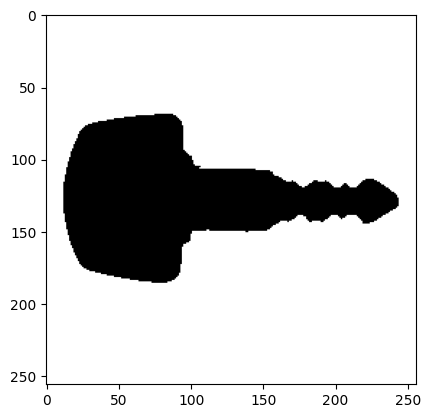

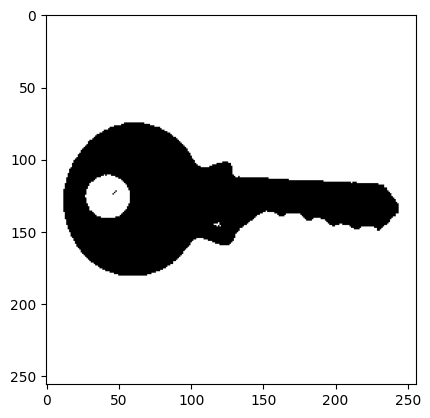

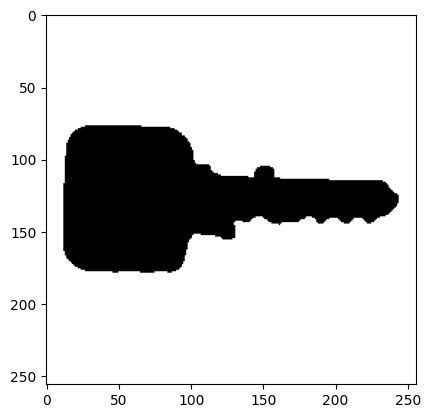

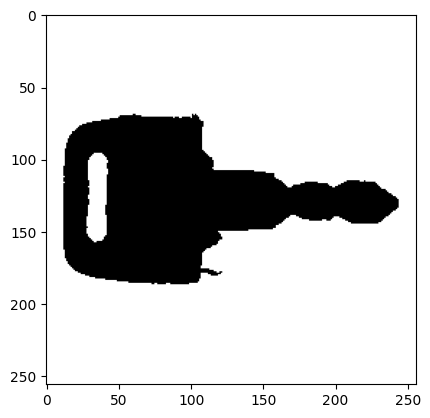

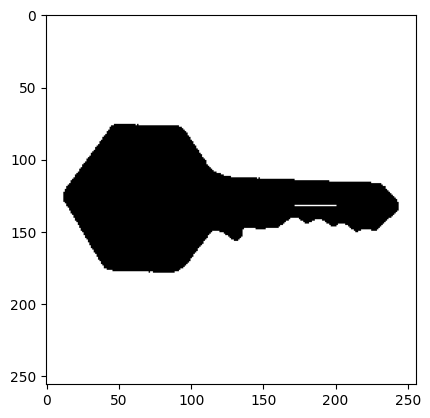

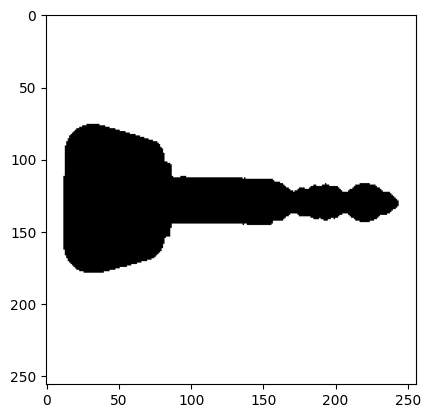

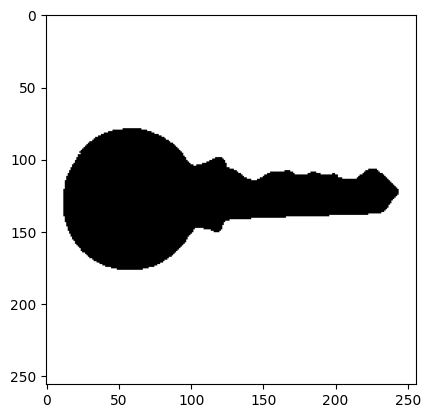

In [17]:
resized_binary_images = []

for image in key_images:
    resized_img = resize_binary_image_to_256x256(image.cropped_mask)
    resized_binary_images.append(resized_img)
    
for resized_img in resized_binary_images:
    plt_img(resized_img, cmap='binary')

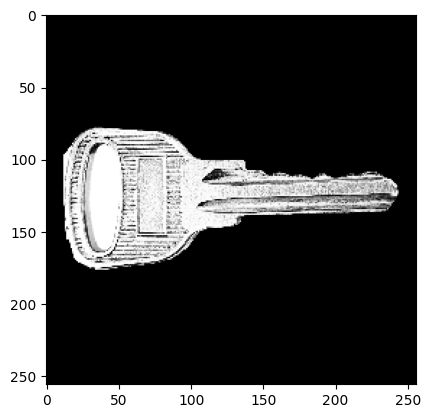

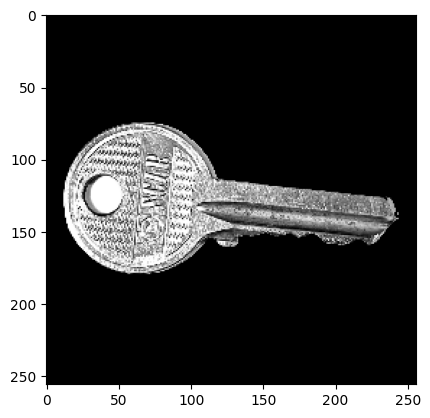

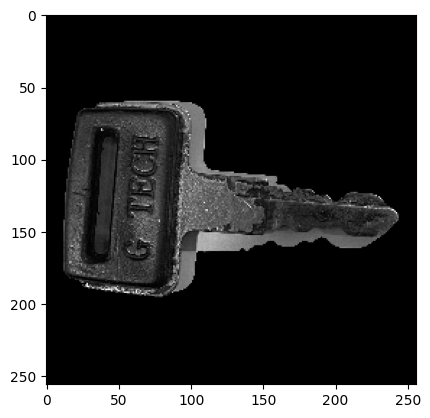

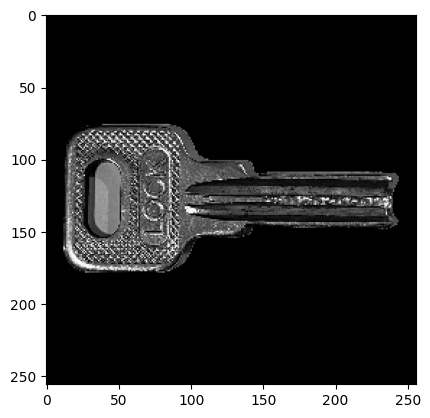

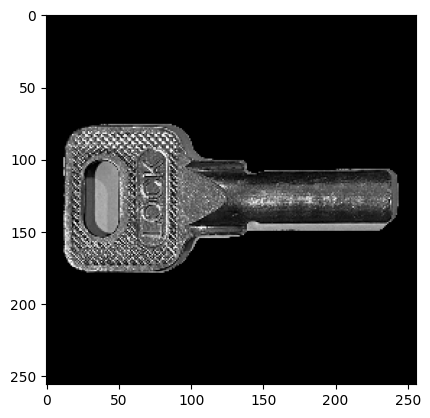

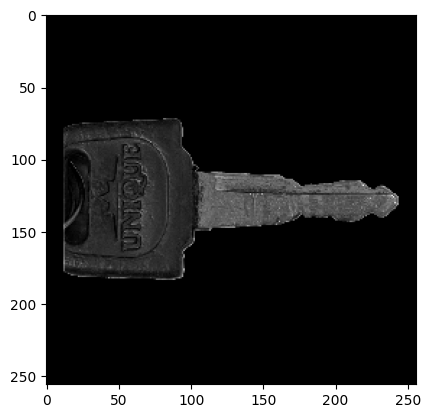

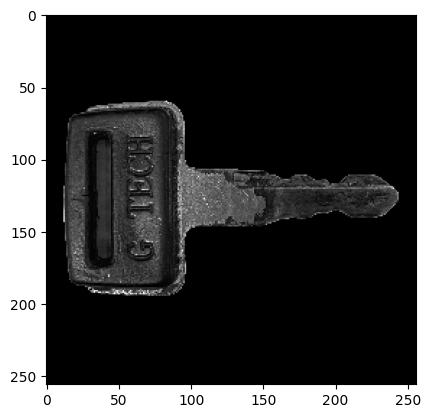

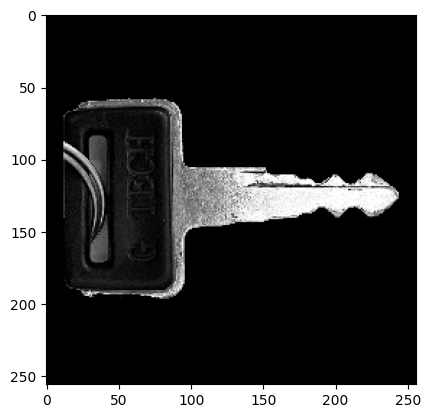

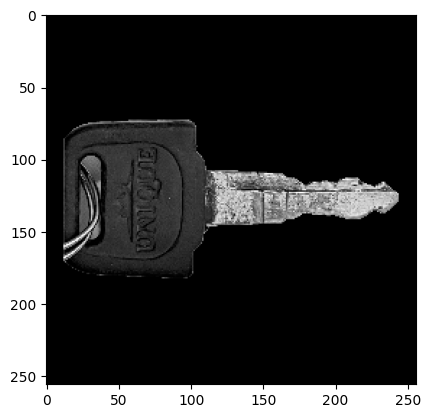

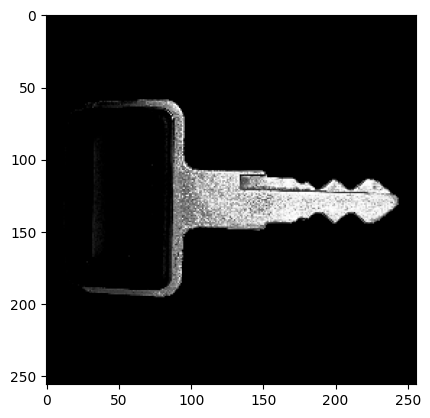

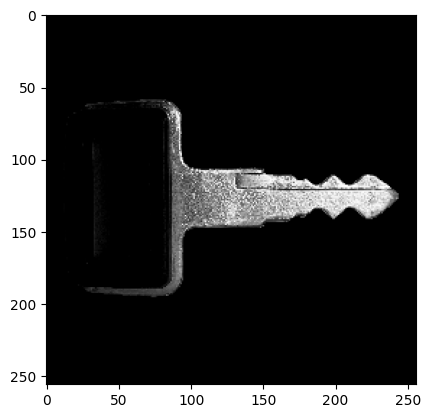

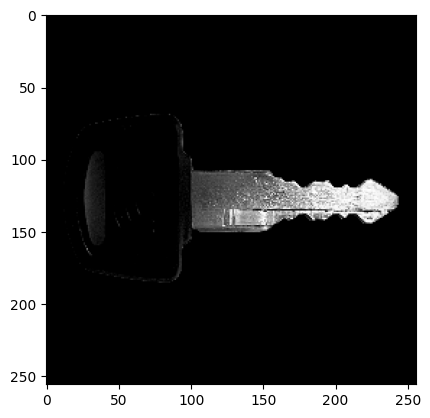

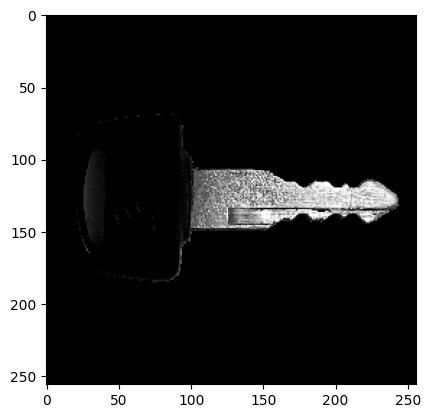

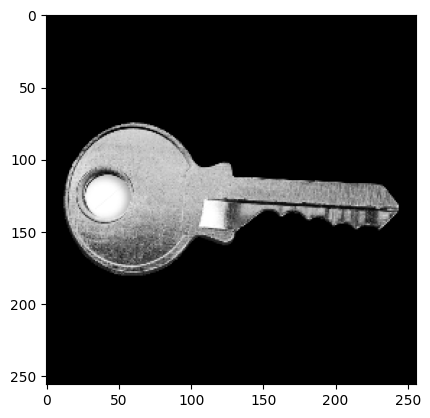

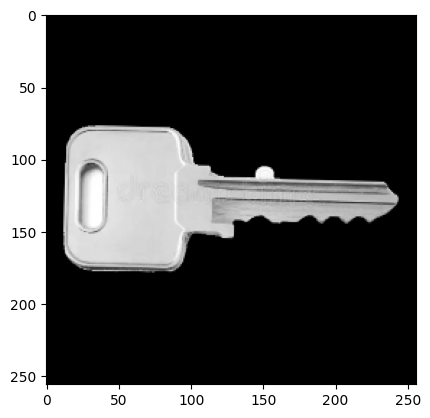

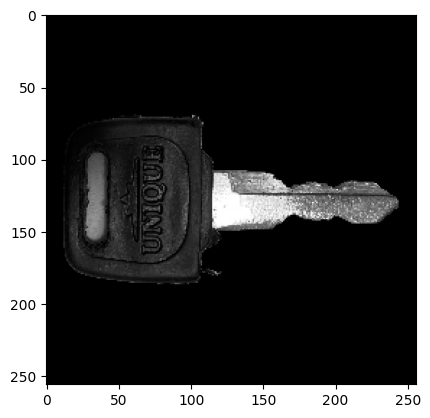

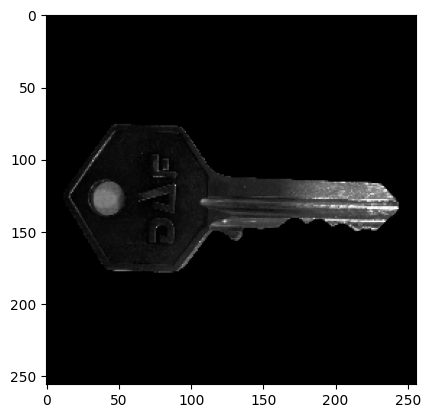

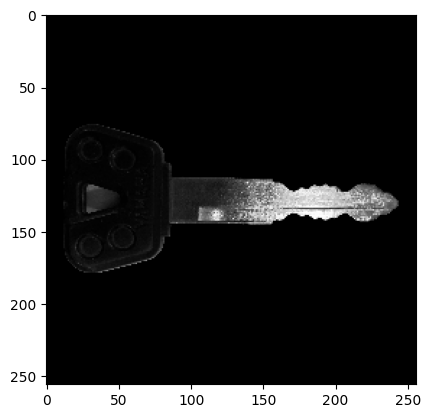

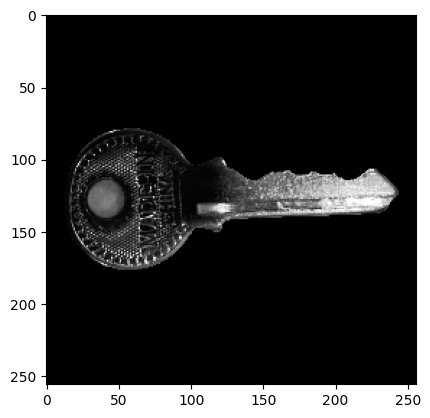

In [18]:
resized_grayscale_images = []

for image in key_images:
    resized_img = resize_grayscale_image_to_256x256(image.cropped_feature)
    resized_grayscale_images.append(resized_img)
    
for resized_img in resized_grayscale_images:
    plt_img(resized_img, cmap='gray')

In [19]:
# # Packed grayscale images bits
# resized_grayscale_packed_images = []

# for img in resized_grayscale_images:
#     packed_bits = pack_bits(img,num_bits=8)
#     resized_grayscale_packed_images.append(packed_bits)

In [20]:
# # Save this list into .csv file
# csv_file = 'features_grayscale_256x256.csv'

# # Write the list of flattened images to CSV
# with open(csv_file, 'w', newline='') as f:
#     writer = csv.writer(f)
#     for img in resized_grayscale_packed_images:
#         writer.writerow(packed_bits)

# Step 4: Store these extracted binary features to .csv

In [21]:
# Create empty list
flatten_images = []

# Loop images to apply bit packing
for resized_img in resized_binary_images:
    bit_packed_image = bit_packing(resized_img)
    flatten_image = bit_packed_image.flatten()
    flatten_images.append(flatten_image)
    
# Save this list into .csv file
csv_file = 'features_256x256.csv'

# Write the list of flattened images to CSV
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    for img in flatten_images:
        writer.writerow(list(img))

# Step 5: Read from .csv file to cross check save image

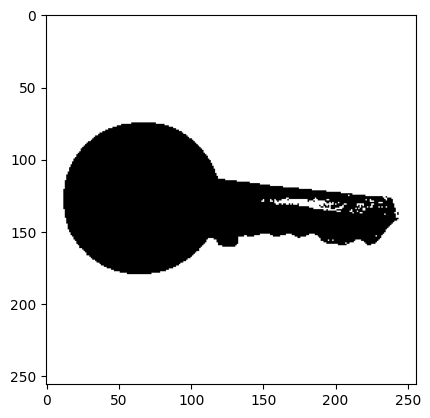

In [22]:
# Read dataframe
df = pd.read_csv('features_256x256.csv')

# Pick first row as sample and converty to uint8
test_img = (df.iloc[0].values).astype(np.uint8)

# Unpack bits to original dimensions
test_img = bit_unpacking(test_img, 256, 256)

# Plot test image
plt_img(test_img, cmap='binary')

# Step 6: Compare binary vs grayscale image cosine similarity score

### Grayscale results

In [23]:
num_images = len(resized_grayscale_images)
confusion_matrix = np.zeros((num_images, num_images))

for i in range(num_images):
    for j in range(num_images):
        flat_img1 = resized_grayscale_images[i].flatten().reshape(1, -1)
        flat_img2 = resized_grayscale_images[j].flatten().reshape(1, -1)

        cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

        confusion_matrix[i, j] = cosine_sim

df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                   index=range(num_images), 
                                   columns=range(num_images))
df_confusion_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,0.778424,0.564602,0.755377,0.769184,0.735036,0.692336,0.597890,0.679476,0.474052,0.502301,0.408821,0.433162,0.853140,0.885527,0.605332,0.472500,0.425467,0.614682
1,0.778424,1.000000,0.627884,0.728977,0.765119,0.667641,0.631773,0.477066,0.580956,0.420196,0.388709,0.341212,0.350004,0.836880,0.845020,0.568648,0.490341,0.392157,0.482718
2,0.564602,0.627884,1.000000,0.539336,0.561287,0.570418,0.665428,0.480377,0.511300,0.458275,0.421289,0.325987,0.349906,0.594659,0.609899,0.519025,0.382235,0.330574,0.345279
3,0.755377,0.728977,0.539336,1.000000,0.738360,0.636264,0.604267,0.460628,0.557300,0.368914,0.372421,0.320158,0.321916,0.737866,0.793243,0.494048,0.434617,0.350399,0.488369
4,0.769184,0.765119,0.561287,0.738360,1.000000,0.672132,0.625102,0.494823,0.590917,0.402310,0.408030,0.360821,0.366182,0.760670,0.818954,0.524157,0.486757,0.384665,0.514454
5,0.735036,0.667641,0.570418,0.636264,0.672132,1.000000,0.685738,0.730462,0.824197,0.715457,0.699795,0.678976,0.698079,0.753774,0.787289,0.788569,0.638129,0.660578,0.670077
6,0.692336,0.631773,0.665428,0.604267,0.625102,0.685738,1.000000,0.622167,0.610819,0.556926,0.538837,0.403650,0.434526,0.683789,0.719547,0.564012,0.415623,0.384786,0.475294
7,0.597890,0.477066,0.480377,0.460628,0.494823,0.730462,0.622167,1.000000,0.758769,0.814351,0.868342,0.730636,0.755422,0.568882,0.591155,0.721379,0.601347,0.683760,0.686340
8,0.679476,0.580956,0.511300,0.557300,0.590917,0.824197,0.610819,0.758769,1.000000,0.736761,0.742469,0.737499,0.744741,0.668789,0.706269,0.793486,0.655676,0.692273,0.712605
9,0.474052,0.420196,0.458275,0.368914,0.402310,0.715457,0.556926,0.814351,0.736761,1.000000,0.871243,0.806162,0.817015,0.500107,0.504425,0.750767,0.632807,0.730586,0.605428


### Binary Results

In [24]:
num_images = len(resized_binary_images)
confusion_matrix = np.zeros((num_images, num_images))

for i in range(num_images):
    for j in range(num_images):
        flat_img1 = resized_binary_images[i].flatten().reshape(1, -1)
        flat_img2 = resized_binary_images[j].flatten().reshape(1, -1)

        cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

        confusion_matrix[i, j] = cosine_sim

df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                   index=range(num_images), 
                                   columns=range(num_images))
df_confusion_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,0.798274,0.747946,0.897170,0.895090,0.887338,0.853951,0.835084,0.898623,0.829532,0.847871,0.888593,0.892448,0.865444,0.915885,0.822113,0.850191,0.863256,0.937050
1,0.798274,1.000000,0.844757,0.855388,0.863001,0.829435,0.763072,0.730774,0.829423,0.777106,0.757922,0.845033,0.843060,0.850610,0.851436,0.805047,0.888736,0.779727,0.813450
2,0.747946,0.844757,1.000000,0.813996,0.815967,0.833406,0.860913,0.836541,0.832479,0.876578,0.856574,0.830987,0.829149,0.761272,0.805019,0.838030,0.793988,0.746545,0.730122
3,0.897170,0.855388,0.813996,1.000000,0.971756,0.894588,0.848026,0.818276,0.902701,0.839502,0.838284,0.887949,0.889098,0.872342,0.921882,0.868852,0.883973,0.828851,0.868247
4,0.895090,0.863001,0.815967,0.971756,1.000000,0.893501,0.844866,0.816167,0.900417,0.837769,0.836070,0.887686,0.888318,0.869402,0.919006,0.861315,0.883217,0.828725,0.866614
5,0.887338,0.829435,0.833406,0.894588,0.893501,1.000000,0.908520,0.883797,0.958196,0.909226,0.904761,0.943733,0.943871,0.863790,0.935363,0.900173,0.875623,0.875534,0.864644
6,0.853951,0.763072,0.860913,0.848026,0.844866,0.908520,1.000000,0.955828,0.897916,0.966447,0.972785,0.900453,0.902879,0.804391,0.876646,0.857930,0.813074,0.819512,0.834170
7,0.835084,0.730774,0.836541,0.818276,0.816167,0.883797,0.955828,1.000000,0.871970,0.948870,0.968274,0.868362,0.871576,0.775335,0.849640,0.827642,0.779485,0.790084,0.813099
8,0.898623,0.829423,0.832479,0.902701,0.900417,0.958196,0.897916,0.871970,1.000000,0.886961,0.888309,0.928752,0.929405,0.854104,0.932411,0.914118,0.881035,0.861385,0.868036
9,0.829532,0.777106,0.876578,0.839502,0.837769,0.909226,0.966447,0.948870,0.886961,1.000000,0.972763,0.905932,0.906331,0.805570,0.872950,0.860224,0.817149,0.825067,0.811865


# Step 8: Test similarity search

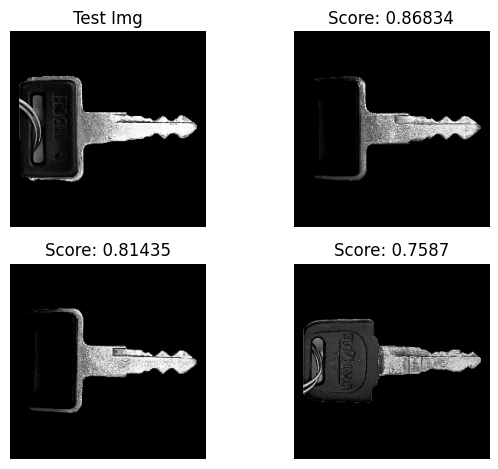

In [41]:
test_img = resized_grayscale_images[7]
score_results = []

for img in resized_grayscale_images:
    flat_img1 = test_img.flatten().reshape(1, -1)
    flat_img2 = img.flatten().reshape(1, -1)
    cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]
    score_results.append(cosine_sim)

# Visualise
fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(resized_grayscale_images[7], cmap='gray')
axs[0,0].set_title('Test Img')
axs[0,0].axis('off')

axs[0,1].imshow(resized_grayscale_images[10], cmap='gray')
axs[0,1].set_title('Score: 0.86834')
axs[0,1].axis('off')

axs[1,0].imshow(resized_grayscale_images[9], cmap='gray')
axs[1,0].set_title('Score: 0.81435')
axs[1,0].axis('off')

axs[1,1].imshow(resized_grayscale_images[8], cmap='gray')
axs[1,1].set_title('Score: 0.7587')
axs[1,1].axis('off')

plt.tight_layout()
plt.show()

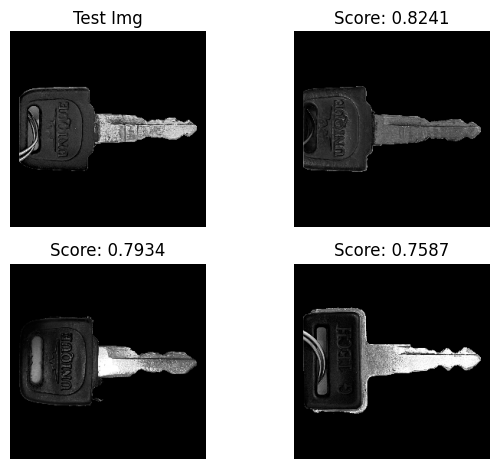

In [42]:
test_img = resized_grayscale_images[7]
score_results = []

for img in resized_grayscale_images:
    flat_img1 = test_img.flatten().reshape(1, -1)
    flat_img2 = img.flatten().reshape(1, -1)
    cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]
    score_results.append(cosine_sim)

# Visualise
fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(resized_grayscale_images[8], cmap='gray')
axs[0,0].set_title('Test Img')
axs[0,0].axis('off')

axs[0,1].imshow(resized_grayscale_images[5], cmap='gray')
axs[0,1].set_title('Score: 0.8241')
axs[0,1].axis('off')

axs[1,0].imshow(resized_grayscale_images[15], cmap='gray')
axs[1,0].set_title('Score: 0.7934')
axs[1,0].axis('off')

axs[1,1].imshow(resized_grayscale_images[7], cmap='gray')
axs[1,1].set_title('Score: 0.7587')
axs[1,1].axis('off')

plt.tight_layout()
plt.show()